In [9]:
import sys
from os.path import join as oj
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.append('../src')
import numpy as np
import data_pecarn, data_psrc
from validate import calc_stats
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import itertools

%matplotlib inline
%load_ext autoreload
%autoreload 2

DATASET = 'PECARN'

if DATASET == 'PECARN':
    d = data_pecarn.get_data(use_processed=True, dummy=True, frac_missing_allowed=1, impute_feats=False)
    iaii = d['iai_intervention']
    iai = d['iai']
    fast_study_cohort, fast_abnormal = data_pecarn.get_FAST(d)    
else:
    d = data_psrc.get_data(use_processed=False, dummy=True) #use_processed_feats=True,)
    iaii = d['iai_intervention']
    iai = d['iai']
    d['FAST (choice=not performed)'] = d['FAST (choice=0t performed)']
    fast_study_cohort, fast_abnormal = data_psrc.get_FAST(d)    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
print('fast options', [k for k in d.keys() if k.lower().startswith('fast')])

fast options []


In [11]:
combs = []
if DATASET == 'PSRC':
    rules = {
        'Abdominal wall trauma or seatbelt sign': d['AbdTrauma_or_SeatBeltSign_yes']==1,
        'GCSScore < 14': d['GCSScore'] < 14,
        'Abdominal tenderness': d['AbdTenderDegree_None'] == 0,
        'FAST': fast_abnormal,
    }
else:
    rules = {
        'Abdominal wall trauma or seatbelt sign': d['AbdTrauma_or_SeatBeltSign_yes']==1,
        'GCSScore < 14': d['GCSScore'] < 14,
        'Abdominal tenderness': d['AbdTenderDegree_unknown'] == 0,
        'FAST': fast_abnormal,
    }
ks = list(rules.keys())
for r in range(len(ks)):
    combs += list(itertools.combinations(ks, r=r + 1))
combs


[('Abdominal wall trauma or seatbelt sign',),
 ('GCSScore < 14',),
 ('Abdominal tenderness',),
 ('FAST',),
 ('Abdominal wall trauma or seatbelt sign', 'GCSScore < 14'),
 ('Abdominal wall trauma or seatbelt sign', 'Abdominal tenderness'),
 ('Abdominal wall trauma or seatbelt sign', 'FAST'),
 ('GCSScore < 14', 'Abdominal tenderness'),
 ('GCSScore < 14', 'FAST'),
 ('Abdominal tenderness', 'FAST'),
 ('Abdominal wall trauma or seatbelt sign',
  'GCSScore < 14',
  'Abdominal tenderness'),
 ('Abdominal wall trauma or seatbelt sign', 'GCSScore < 14', 'FAST'),
 ('Abdominal wall trauma or seatbelt sign', 'Abdominal tenderness', 'FAST'),
 ('GCSScore < 14', 'Abdominal tenderness', 'FAST'),
 ('Abdominal wall trauma or seatbelt sign',
  'GCSScore < 14',
  'Abdominal tenderness',
  'FAST')]

In [12]:
outcome = iaii
r = defaultdict(list)
for comb in combs:
    preds = np.zeros_like(outcome)
    for k in comb:
        preds = preds | rules[k]
    tn, fp, fn, tp, sens, spec = calc_stats(outcome[fast_study_cohort],
                                            preds[fast_study_cohort])
    r['sens'].append(sens)
    r['spec'].append(spec)
    r['fast'].append('FAST' in comb)
    r['rules'].append(comb)
r = pd.DataFrame.from_dict(r)

In [13]:
pd.set_option('display.max_colwidth', None)
r.round(2).sort_values(by=['sens', 'spec'], ascending=False)

,sens,spec,fast,rules
10,0.83,0.60,False,"(Abdominal wall trauma or seatbelt sign, GCSScore < 14, Abdominal tenderness)"
14,0.83,0.60,True,"(Abdominal wall trauma or seatbelt sign, GCSScore < 14, Abdominal tenderness, FAST)"
11,0.80,0.73,True,"(Abdominal wall trauma or seatbelt sign, GCSScore < 14, FAST)"
13,0.80,0.68,True,"(GCSScore < 14, Abdominal tenderness, FAST)"
4,0.77,0.74,False,"(Abdominal wall trauma or seatbelt sign, GCSScore < 14)"
7,0.73,0.69,False,"(GCSScore < 14, Abdominal tenderness)"
5,0.70,0.69,False,"(Abdominal wall trauma or seatbelt sign, Abdominal tenderness)"
12,0.70,0.68,True,"(Abdominal wall trauma or seatbelt sign, Abdominal tenderness, FAST)"
6,0.67,0.81,True,"(Abdominal wall trauma or seatbelt sign, FAST)"
9,0.67,0.78,True,"(Abdominal tenderness, FAST)"


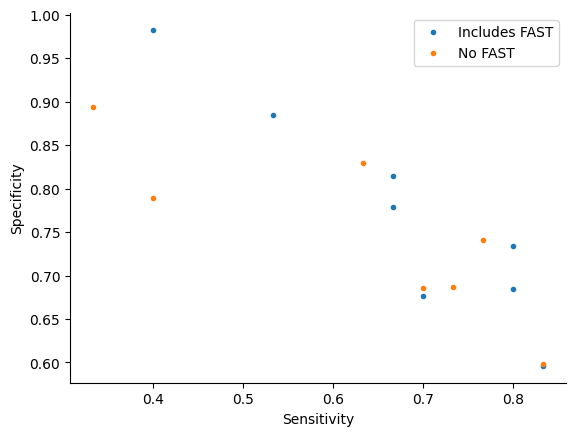

In [14]:
plt.plot(r['sens'][r['fast']], r['spec'][r['fast']], '.', label='Includes FAST')
plt.plot(r['sens'][~r['fast']], r['spec'][~r['fast']], '.', label='No FAST')
plt.xlabel('Sensitivity')
plt.ylabel('Specificity')
plt.legend()
plt.show()